## Read Me
Jingyan Jiang  
Andrew ID: jingyanj

### 1. How to run
Just run the blocks one by one in the following order

### 2.Experiments
#### (1)

#### (2)

#### (3)

### 3. Best Combination
The first one is the best combination

In [5]:
!pip install python-levenshtein

     |████████████████████████████████| 50 kB 2.6 MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149861 sha256=21de73ed0b2663a84ae4623a239b75bbb0045934a3d80eaad0389c07b095d832
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-levenshtein


# Libraries and Initial Processing

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import Levenshtein as lev
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import datetime
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import Levenshtein
from tqdm import tqdm

cuda = torch.cuda.is_available()

print(cuda, sys.version)

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))
np.random.seed(11785)
torch.manual_seed(11785)

# The labels of the dataset contain letters in LETTER_LIST.
# You should use this to convert the letters to the corresponding indices
# and train your model with numerical labels.
LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>']

True 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Cuda = True with num_workers = 4


In [2]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    based on LETTER_LIST


    Args:
        letter_list: LETTER_LIST

    Return:
        letter2index: Dictionary mapping from letters to indices
        index2letter: Dictionary mapping from indices to letters
    '''
    letter2index = dict(zip(letter_list, range(len(letter_list))))
    index2letter = dict(zip(range(len(letter_list)), letter_list))
    
    return letter2index, index2letter
    

def transform_index_to_letter(batch_indices):
    '''
    Transforms numerical index input to string output by converting each index 
    to its corresponding letter from LETTER_LIST

    Args:
        batch_indices: List of indices from LETTER_LIST with the shape of (N, )
    
    Return:
        transcripts: List of converted string transcripts. This would be a list with a length of N
    '''
    transcripts = []
    # TODO
    for idx in batch_indices:
      tmp = ""
      for i in idx:
        if i == 0:
          pass
        elif i == 29:
          break
        else:
          tmp += index2letter[i]
      transcripts.append(tmp)
    return transcripts
        
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

# Kaggle (TODO)

In [3]:
import json

TOKEN = {"username":"shawnjjy","key":"8aafc474d04fb8ac8d41c290ae9ef800"}

! pip install kaggle==1.5.12
! mkdir -p .kaggle
! mkdir -p /content & mkdir -p /content/.kaggle & mkdir -p /root/.kaggle/

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(TOKEN, file)

! pip install --upgrade --force-reinstall --no-deps kaggle
! ls "/content/.kaggle"
! chmod 600 /content/.kaggle/kaggle.json
! cp /content/.kaggle/kaggle.json /root/.kaggle/

! kaggle config set -n path -v /content

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
kaggle.json
- path is now set to: /content


In [13]:
! kaggle competitions download -c 11-785-s22-hw4p2

100% 1.84G/1.84G [00:57<00:00, 24.9MB/s]
100% 1.84G/1.84G [00:57<00:00, 34.3MB/s]


In [14]:
! unzip /content/competitions/11-785-s22-hw4p2/11-785-s22-hw4p2.zip

Streaming output truncated to the last 5000 lines.
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-019.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-020.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-021.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-022.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-023.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-024.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-025.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-026.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-027.npy  
  inflating: hw4p2_student_data/hw4p2_student_data/train/transcript/7113-086041-028.npy  
  inflating: hw4p2_student_data/hw4p2_student_dat

# Dataset and Dataloading (TODO)

You will need to implement the Dataset class by your own. You can implement it similar to HW3P2. However, you are welcomed to do it your own way if it is more comfortable or efficient.

Note that you need to use LETTER_LIST to convert the transcript into numerical labels for the model.


Example of raw transcript:

    ['<sos>', 'N', 'O', 'R', 'T', 'H', 'A', 'N', 'G', 'E', 'R', ' ','A', 'B', 'B', 'E', 'Y', '<eos>']

Example of converted transcript ready to process for the model:

    [0, 14, 15, 18, 20, 8, 1, 14, 7, 5, 18, 28, 1, 2, 2, 5, 25, 29]


In [4]:
class LibriSamples(torch.utils.data.Dataset):

    def __init__(self, data_path, partition= "train"):

        self.X_dir = data_path + "/"+partition + "/mfcc/" # TODO: get mfcc directory path
        self.Y_dir = data_path + "/"+partition + "/transcript/"# TODO: get transcript path

        self.X_files = os.listdir(self.X_dir) # TODO: list files in the mfcc directory
        self.Y_files = os.listdir(self.Y_dir) # TODO: list files in the transcript directory

        self.LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>']


    def __len__(self):
        return len(self.X_files)

    def __getitem__(self, ind):

        X = np.load(self.X_dir + self.X_files[ind], allow_pickle = True, encoding='bytes') # TODO: Load the mfcc npy file at the specified index ind in the directory
        Y = np.load(self.Y_dir + self.Y_files[ind], allow_pickle = True, encoding='bytes') # TODO: Load the corresponding transcripts
        label = [self.LETTER_LIST.index(yy) for yy in Y[1:-1]]
        X = torch.FloatTensor(X)
        Y = torch.LongTensor(label) # TODO: Convert sequence of phonemes into sequence of Long tensors
        return X, Y
    
def collate_fn(batch):

        # TODO
         batch_x = [x for x,y in batch]
         batch_y = [y for x,y in batch]

         batch_x_pad = pad_sequence(batch_x, batch_first = True, padding_value=0) # TODO: pad the sequence with pad_sequence (already imported)
         lengths_x = [len(x) for x in batch_x]# TODO: Get original lengths of the sequence before padding

         batch_y_pad = pad_sequence(batch_y,batch_first = True, padding_value=0) # TODO: pad the sequence with pad_sequence (already imported)
         lengths_y = [len(y) for y in batch_y] # TODO: Get original lengths of the sequence before padding

         return batch_x_pad, batch_y_pad, torch.LongTensor(lengths_x), torch.LongTensor(lengths_y)


class LibriSamplesTest(torch.utils.data.Dataset):

    def __init__(self, data_path, test_order):

        # TODO
        self.X_dir = data_path + "/"+"test" + "/mfcc/"
        test_order_list = np.array(pd.read_csv(data_path+ "/"+"test" + "/"+test_order))# TODO: open test_order.csv as a list
        self.X = [np.load(self.X_dir+file[0], allow_pickle = True) for file in test_order_list] # TODO: Load the npy files from test_order.csv and append into a list
        
    
    def __len__(self):
        # TODO
        return len(self.X)
    
    def __getitem__(self, ind):
        # TODO
        return torch.FloatTensor(self.X[ind])
    
def collate_fntest(batch):
    # TODO
    batch_x = [x for x in batch]
    batch_x_pad = pad_sequence(batch_x, batch_first = True, padding_value=0) # TODO: pad the sequence with pad_sequence (already imported)
    lengths_x = torch.LongTensor([len(x) for x in batch_x]) # TODO: Get original lengths of the sequence before padding

    return batch_x_pad, lengths_x

In [5]:
batch_size = 128

root = '/content/hw4p2_student_data/hw4p2_student_data'

train_data = LibriSamples(root, 'train')
val_data = LibriSamples(root, 'dev')
test_data = LibriSamplesTest(root, 'test_order.csv')

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, collate_fn = collate_fn, num_workers=0, pin_memory=True) # TODO: Define the train loader. Remember to pass in a parameter (function) for the collate_fn argument 

val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False, collate_fn = collate_fn, num_workers=0, pin_memory=True) # TODO: Define the val loader. Remember to pass in a parameter (function) for the collate_fn argument 

test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, collate_fn = collate_fntest, num_workers=0, pin_memory=True) # TODO: Define the test loader. Remember to pass in a parameter (function) for the collate_fn argument 



print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  128
Train dataset samples = 28539, batches = 223
Val dataset samples = 2703, batches = 22
Test dataset samples = 2620, batches = 21


In [6]:
# test code for checking shapes
for data in val_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, len(ly))
    print(y[0]) # desired 
    break

torch.Size([128, 3248, 13]) torch.Size([128, 515]) torch.Size([128]) 128
tensor([ 4, 15, 28, 20,  8,  5, 25, 28, 19, 20,  9, 12, 12, 28,  9, 14, 19,  9,
        19, 20, 28, 20,  8,  1, 20, 28, 13,  9, 19, 19, 28,  3,  8,  1, 12, 12,
        15, 14,  5, 18, 28, 23,  1, 19, 28, 20,  8,  5, 28, 15, 14, 12, 25, 28,
        16,  5, 18, 19, 15, 14, 28,  9, 14, 28, 20,  8,  5, 28, 18, 15, 15, 13,
        28, 23,  9, 20,  8, 28, 20,  8,  5, 13, 28,  1, 20, 28, 20,  8,  9, 19,
        28, 20,  9, 13,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

# Model (TODO)

In [7]:
from torch.autograd import Variable
#cuda = torch.cuda.is_available()
#device = torch.device("cuda" if cuda else "cpu")
class LockedDropout(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x, dropout=0.5):
  # x': (B, L, C)
    if dropout == 0 or not self.training:
      return x
    mask = x.data.new(x.size(0), 1, x.size(2))
    mask = mask.bernoulli_(1 - dropout)
    mask = Variable(mask, requires_grad=False) / (1 - dropout)
    mask = mask.expand_as(x)
    return mask * x

In [8]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed
    2. Truncate the input length dimension by concatenating feature dimension
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim*2, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.dropout = LockedDropout()
    def forward(self, x):
        x_padded, x_lens = pad_packed_sequence(x, batch_first=True)
        x_padded = x_padded[:, :(x_padded.size(1) // 2) * 2, :] # chop off 
        x_padded = x_padded.reshape(x_padded.size(0), x_padded.size(1) // 2, x_padded.size(2) * 2)
        x_padded = self.dropout(x_padded) # lock dropout layer
        x_packed = pack_padded_sequence(x_padded, lengths=x_lens // 2, batch_first=True, enforce_sorted=False)
        out, _ = self.blstm(x_packed)
        return out

In [9]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.

    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):
        super(Encoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, encoder_hidden_dim//2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Conv1d(encoder_hidden_dim//2,encoder_hidden_dim,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(encoder_hidden_dim),
            )
        # The first LSTM layer at the bottom
        self.lstm = nn.LSTM(input_size=encoder_hidden_dim, hidden_size=encoder_hidden_dim, num_layers=1, bidirectional=True, batch_first = True)

        # Define the blocks of pBLSTMs
        # Dimensions should be chosen carefully
        # Hint: Bidirectionality, truncation...
        self.pBLSTMs = nn.Sequential(
            pBLSTM(2*encoder_hidden_dim, encoder_hidden_dim),            
            pBLSTM(2*encoder_hidden_dim, encoder_hidden_dim),
            pBLSTM(2*encoder_hidden_dim, encoder_hidden_dim),            
        )
         
        # The linear transformations for producing Key and Value for attention
        # Hint: Dimensions when bidirectional lstm? 
        self.key_network = nn.Linear(encoder_hidden_dim*2, key_value_size)
        self.value_network = nn.Linear(encoder_hidden_dim*2, key_value_size)

    def forward(self, x, x_len):
        """
        1. Pack your input and pass it through the first LSTM layer (no truncation)
        2. Pass it through the pyramidal LSTM layer
        3. Pad your input back to (B, T, *) or (T, B, *) shape
        4. Output Key, Value, and truncated input lens

        Key and value could be
            (i) Concatenated hidden vectors from all time steps (key == value).
            (ii) Linear projections of the output from the last pBLSTM network.
                If you choose this way, you can use the final output of
                your pBLSTM network.
        """

        x = x.transpose(1,2)
        x = self.cnn(x)
        x = x.transpose(1,2)

        # x is returned from the dataloader. So it is assumed to be padded with the help of the collate_fn
        packed_input = pack_padded_sequence(x, lengths = x_len.cpu(), enforce_sorted= False, batch_first=True).to(device)# TODO: Pack the input with pack_padded_sequence. Look at the parameters it requires

        out1, out2 = self.lstm(packed_input) # TODO: Pass packed input to self.lstm
        out = self.pBLSTMs(out1)
        
        input, len = pad_packed_sequence(out, batch_first=True)
        keys = self.key_network(input)
        value = self.value_network(input)

        return keys, value, len

        

In [10]:
encoder = # fill this out
# Try out your encoder on a tiny input before moving to the next step...
print()

SyntaxError: ignored

In [12]:
def plot_attention(attention):
    # utility function for debugging
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
    '''
    Attention is calculated using key and value from encoder and query from decoder.
    Here are different ways to compute attention and context:
    1. Dot-product attention
        energy = bmm(key, query) 
        # Optional: Scaled dot-product by normalizing with sqrt key dimension
        # Check "attention is all you need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore...
    2. Cosine attention
        energy = cosine(query, key) # almost the same as dot-product xD 
    3. Bi-linear attention
        W = Linear transformation (learnable parameter): d_k -> d_q
        energy = bmm(key @ W, query)
    4. Multi-layer perceptron
        # Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4
    
    After obtaining unnormalized attention weights (energy), compute and return attention and context, i.e.,
    energy = mask(energy) # mask out padded elements with big negative number (e.g. -1e9)
    attention = softmax(energy)
    context = bmm(attention, value)

    5. Multi-Head Attention
        # Check "attention is all you need" Section 3.2.2
        h = Number of heads
        W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
        W_O: d_v -> d_v

        Reshape K: (B, T, d_k)
        to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
        Reshape V: (B, T, d_v)
        to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
        Reshape Q: (B, d_q)
        to (B, h, d_q // h)

        energy = Q @ K^T
        energy = mask(energy)
        attention = softmax(energy)
        multi_head = attention @ V
        multi_head = multi_head reshaped to (B, d_v)
        context = multi_head @ W_O
    '''
    def __init__(self):
        super(Attention, self).__init__()
        # Optional: dropout

    def forward(self, query, key, value, mask):
        """
        input:
            key: (batch_size, seq_len, d_k)
            value: (batch_size, seq_len, d_v)
            query: (batch_size, d_q)
        * Hint: d_k == d_v == d_q is often true if you use linear projections
        return:
            context: (batch_size, key_val_dim)
        
        """
        key = key.to(device)
        attention = torch.bmm(key, query.unsqueeze(2)).squeeze(2).to(device)
        
        mask = mask.to(device)
        attention.masked_fill_(mask, -1e9)
        attention = nn.functional.softmax(attention, dim=1)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)

        return context, attention
        # we return attention weights for plotting (for debugging)

In [13]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
    Thus we use LSTMCell instead of LSTM here.
    The output from the last LSTMCell can be used as a query for calculating attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Decoder, self).__init__()
        # Hint: Be careful with the padding_idx
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=letter2index['<eos>'])
        # The number of cells is defined based on the paper
        self.lstm1 = nn.LSTMCell(input_size=embed_dim + key_value_size, hidden_size=decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size=decoder_hidden_dim, hidden_size=key_value_size)
    
        self.attention = Attention()     
        self.vocab_size = vocab_size
        self.linear = nn.Linear(2 * key_value_size, 4 * key_value_size)
        self.tanh1 = nn.Tanh()
        self.linear2 = nn.Linear(4*key_value_size, embed_dim)
        self.tanh2 = nn.Tanh()
        # Optional: Weight-tying
        self.character_prob = nn.Linear(2 * key_value_size, vocab_size) #: d_v -> vocab_size
        self.key_value_size = key_value_size
        self.hidden_dim = decoder_hidden_dim
        
        # Weight tying
        self.character_prob.weight = self.embedding.weight

    def forward(self, key, value, encoder_len, y=None, mode='train', Teacher_forcing_rate = 0.9):
        '''
        Args:
            key :(B, T, d_k) - Output of the Encoder (possibly from the Key projection layer)
            value: (B, T, d_v) - Output of the Encoder (possibly from the Value projection layer)
            y: (B, text_len) - Batch input of text with text_length
            mode: Train or eval mode for teacher forcing
        Return:
            predictions: the character perdiction probability 
        '''

        B, key_seq_max_len, key_value_size = key.shape

        if mode == 'train':
            max_len =  y.shape[1]
            char_embeddings = self.embedding(y.long())
        else:
            max_len = 600

        # TODO: Create the attention mask here (outside the for loop rather than inside) to aviod repetition
        mask = torch.arange(key_seq_max_len).unsqueeze(0) >= encoder_len.unsqueeze(1)
        mask = mask.to(device)
        
        predictions = []
        # This is the first input to the decoder
        # What should the fill_value be?
        prediction =  torch.zeros(B, 1).to(device)
        # The length of hidden_states vector should depend on the number of LSTM Cells defined in init
        # The paper uses 2
        hidden_states = [None, None] 
        
        # TODO: Initialize the context
        context = value[:,0,:].squeeze(1)

        attention_plot = [] # this is for debugging

        for i in range(max_len):
            if mode == 'train':
                # TODO: Implement Teacher Forcing
                """
                if using teacher_forcing:
                    if i == 0:
                        # This is the first time step
                        # Hint: How did you initialize "prediction" variable above?
                    else:
                        # Otherwise, feed the label of the **previous** time step
                else:
                    char_embed = embedding of the previous prediction
                """
                if np.random.random_sample() < Teacher_forcing_rate and i>0:
                  char_embed = char_embeddings[:,i-1]
                else:
                  char_embed = self.embedding(prediction.argmax(dim=-1))                
            else:
                char_embed = self.embedding(prediction.argmax(dim=-1)) # embedding of the previous prediction

            # what vectors should be concatenated as a context?
            y_context = torch.cat([char_embed, context], dim=1)
            # context and hidden states of lstm 1 from the previous time step should be fed
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])

            # hidden states of lstm1 and hidden states of lstm2 from the previous time step should be fed
            hidden_states[1] = self.lstm2(hidden_states[0][0], hidden_states[1])
            # What then is the query?
            query = hidden_states[1][0]
            
            # Compute attention from the output of the second LSTM Cell
            context, attention = self.attention(query, key, value, mask)
            # We store the first attention of this batch for debugging
            attention_plot.append(attention[0].detach().cpu())
            
            # What should be concatenated as the output context?
            output_context = torch.cat([query, context], dim=1)
            output_context = self.linear(output_context)
            output_context = self.tanh1(output_context)
            output_context = self.linear2(output_context)
            output_context = self.tanh2(output_context)
            prediction = self.character_prob(output_context)
            # store predictions
            predictions.append(prediction.unsqueeze(1))
        
        # Concatenate the attention and predictions to return
        attentions = torch.stack(attention_plot, dim=0)
        predictions = torch.cat(predictions, dim=1)
        return predictions, attentions

In [14]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim, key_value_size=key_value_size)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, key_value_size=key_value_size)

    def forward(self, x, x_len, y=None, mode='train',Teacher_forcing_rate=0.9):
        key, value, encoder_len = self.encoder(x, x_len)
        predictions = self.decoder(key, value, encoder_len, y=y, mode=mode)
        return predictions

In [15]:
model = Seq2Seq(input_dim=13, vocab_size=len(LETTER_LIST), encoder_hidden_dim=256, decoder_hidden_dim=512, embed_dim=256, key_value_size=128).to(device)

model = model.to(device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (cnn): Sequential(
      (0): Conv1d(13, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.2, inplace=False)
      (3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
        (dropout): LockedDropout()
      )
      (1): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
        (dropout): LockedDropout()
      )
      (2): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
        (dropout): LockedDropout()
      )
    )
    (key_network): Linear(in_features=512, out_features=128, bias=True)
    (value_network): Linear(in_features=512, out_fe

# Training

In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5)
criterion = nn.CrossEntropyLoss(reduction='none')

In [17]:
def train(model, train_loader, criterion, optimizer, mode,Teacher_forcing_rate, scaler):
    model.train()
    model.to(device)
    running_loss = 0
    
    # 0) Iterate through your data loader
    for i, (x,y,x_len,y_len) in enumerate(train_loader):
        
        # 1) Send the inputs to the device
        x,x_len,y,y_len = x.to(device), x_len.to(device), y.long().to(device), y_len.to(device)

        # 2) Pass your inputs, and length of speech into the model.
        predictions, attentions = model(x, x_len, y=y, mode='train',Teacher_forcing_rate=Teacher_forcing_rate)
        
        # 3) Generate a mask based on target length. This is to mark padded elements
        # so that we can exclude them from computing loss.
        # Ensure that the mask is on the device and is the correct shape.
        mask = torch.zeros(y.T.shape).to(device)
        for idx, length_Y in enumerate(y_len):
              mask[:length_Y,idx] = 1    
        # 4) Make sure you have the correct shape of predictions when putting into criterion
        loss = criterion(predictions.view(-1, predictions.size(2)), y.view(-1)) 
        # Use the mask you defined above to compute the average loss
        masked_loss =  torch.sum(loss * mask.view(-1)) / torch.sum(mask)
        running_loss += float(masked_loss.item())

        # 5) backprop
        scaler.scale(masked_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #masked_loss.backward()
        # Optional: Gradient clipping
        #nn.utils.clip_grad_norm_(model.parameters(), 5)

        # When computing Levenshtein distance, make sure you truncate prediction/target
        #optimizer.step()

        # Optional: plot your attention for debugging
    
        
        if i % 50 == 0:
            plot_attention(attentions)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, i*len(x_len), len(train_loader.dataset),
                        100. * i / len(train_loader), running_loss / (i+1)))
        torch.cuda.empty_cache(); del x, y, x_len, y_len
    #print(f'average loss: {running_loss / len(train_loader):.2f}')

def val(model, valid_loader):
    model.eval()
    model.to(device)
    running_dist = 0
    tot_sec = 0
    with torch.no_grad():
      for i, (x,y,x_len,y_len) in enumerate(valid_loader):
        x,x_len,y,y_len = x.to(device), x_len.to(device), y.long().to(device), y_len.to(device)
        pred = model(x,x_len,y=y,mode = 'eval')
        #print(pred, type(pred))
        predtext = transform_index_to_letter(pred[0].detach().cpu().numpy().argmax(-1))
        targettext = transform_index_to_letter(y.detach().cpu().numpy())
        for p, t in zip(predtext, targettext):
          dist = Levenshtein.distance(p,t)
          running_dist += dist
          tot_sec +=1
    print('Avg-distance: {:.5f}'.format(running_dist/tot_sec))
    return running_dist/tot_sec





In [18]:
def evaluate(model, test_loader):
  model.eval()
  model.to(device)
  out = []
  with torch.no_grad():
    for i, (x,x_len) in enumerate(test_loader):
      x, x_len = x.to(device), x_len.to(device)
      pred = model(x,x_len,mode='eval')
      predtext = transform_index_to_letter(pred[0].detach().cpu().numpy().argmax(-1))
      out.extend(predtext)
  return out

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


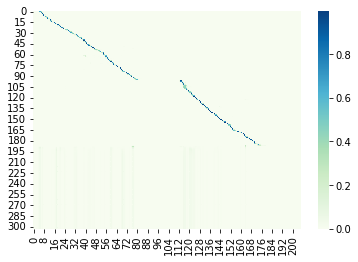

Train Epoch: 0 [0/28539 (0%)]	Loss: 0.111875


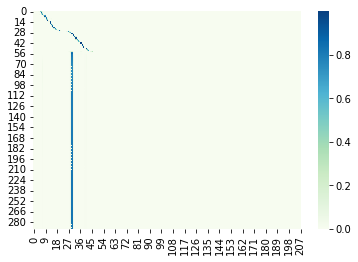

Train Epoch: 0 [6400/28539 (22%)]	Loss: 0.126673


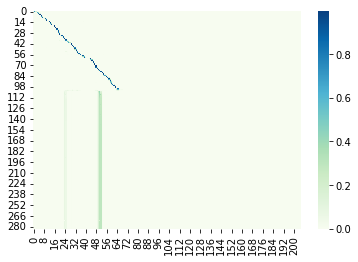

Train Epoch: 0 [12800/28539 (45%)]	Loss: 0.118469


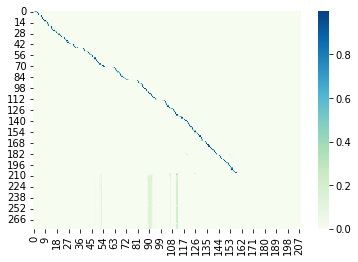

Train Epoch: 0 [19200/28539 (67%)]	Loss: 0.116238


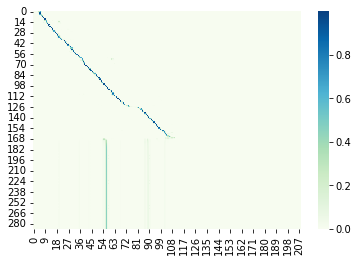

Train Epoch: 0 [25600/28539 (90%)]	Loss: 0.115412
Avg-distance: 16.14058


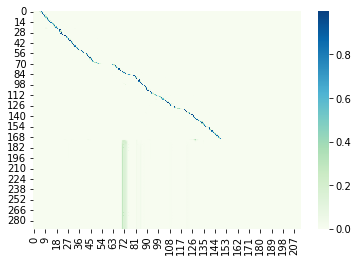

Train Epoch: 1 [0/28539 (0%)]	Loss: 0.103699


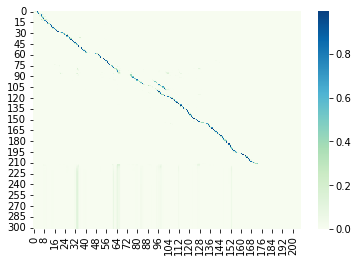

Train Epoch: 1 [6400/28539 (22%)]	Loss: 0.106335


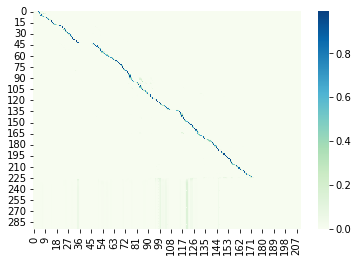

Train Epoch: 1 [12800/28539 (45%)]	Loss: 0.108036


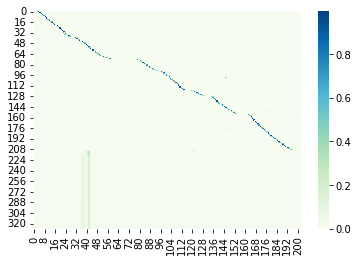

Train Epoch: 1 [19200/28539 (67%)]	Loss: 0.107956


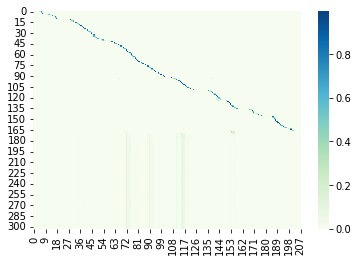

Train Epoch: 1 [25600/28539 (90%)]	Loss: 0.108658
Avg-distance: 16.62375


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


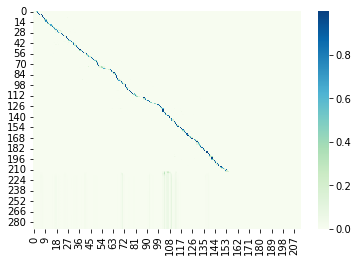

Train Epoch: 2 [0/28539 (0%)]	Loss: 0.095376


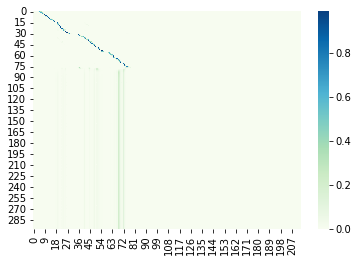

Train Epoch: 2 [6400/28539 (22%)]	Loss: 0.103279


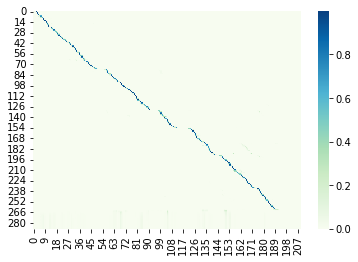

Train Epoch: 2 [12800/28539 (45%)]	Loss: 0.105407


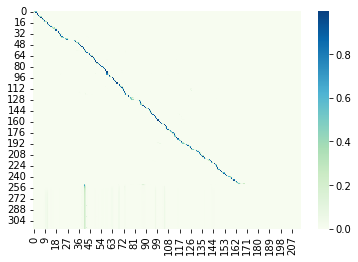

Train Epoch: 2 [19200/28539 (67%)]	Loss: 0.106308


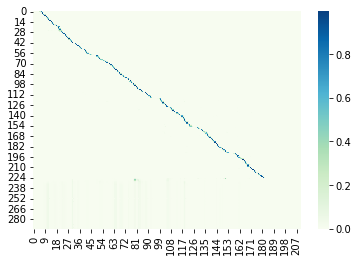

Train Epoch: 2 [25600/28539 (90%)]	Loss: 0.105606
Avg-distance: 15.89752


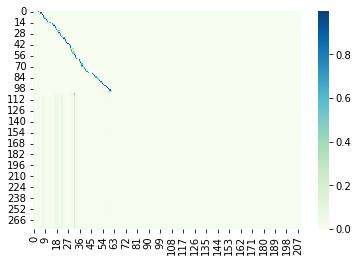

Train Epoch: 3 [0/28539 (0%)]	Loss: 0.103857


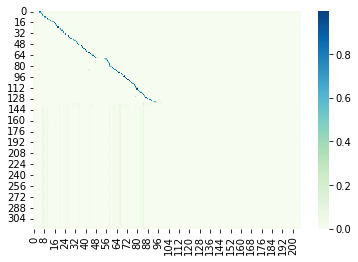

Train Epoch: 3 [6400/28539 (22%)]	Loss: 0.100546


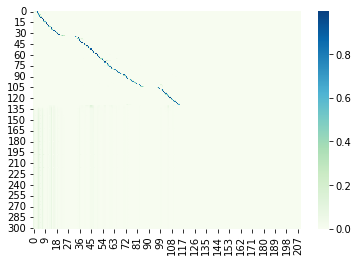

Train Epoch: 3 [12800/28539 (45%)]	Loss: 0.100958


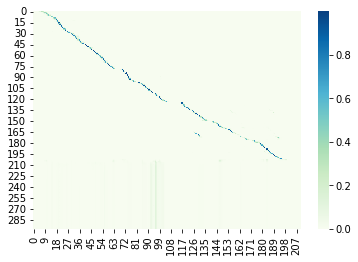

Train Epoch: 3 [19200/28539 (67%)]	Loss: 0.102311


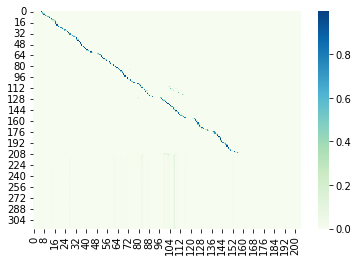

Train Epoch: 3 [25600/28539 (90%)]	Loss: 0.101597
Avg-distance: 15.05919


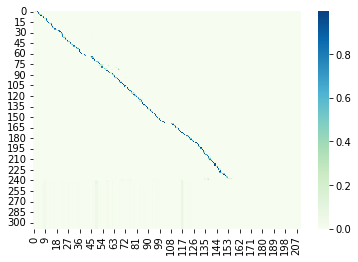

Train Epoch: 4 [0/28539 (0%)]	Loss: 0.105987


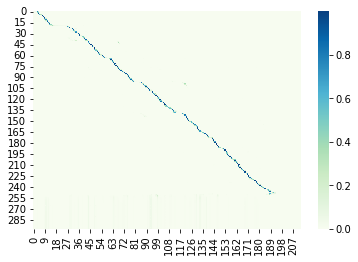

Train Epoch: 4 [6400/28539 (22%)]	Loss: 0.094854


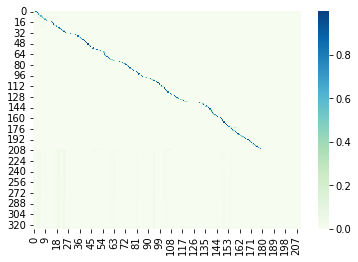

Train Epoch: 4 [12800/28539 (45%)]	Loss: 0.095955


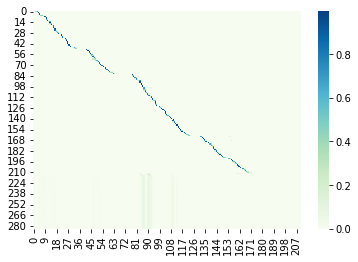

Train Epoch: 4 [19200/28539 (67%)]	Loss: 0.096672


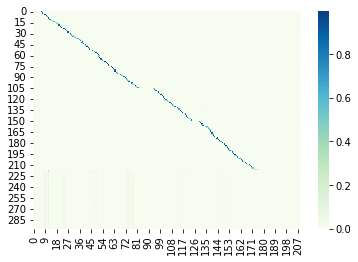

Train Epoch: 4 [25600/28539 (90%)]	Loss: 0.096506
Avg-distance: 14.72660


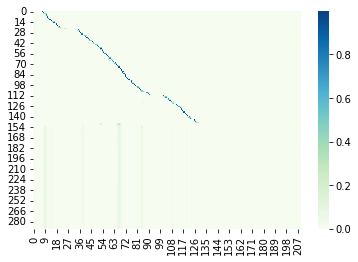

Train Epoch: 5 [0/28539 (0%)]	Loss: 0.090464


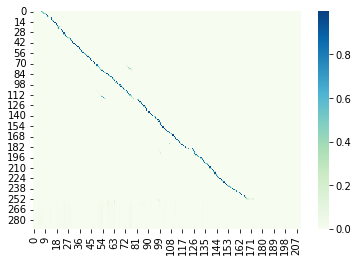

Train Epoch: 5 [6400/28539 (22%)]	Loss: 0.089578


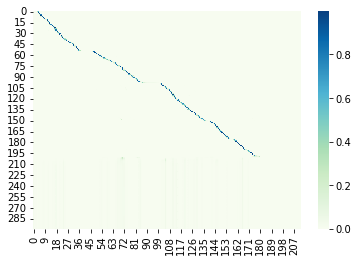

Train Epoch: 5 [12800/28539 (45%)]	Loss: 0.090997


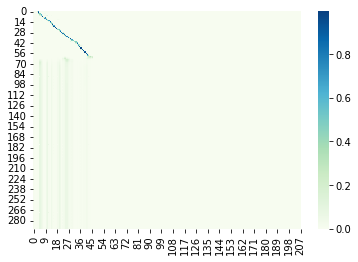

Train Epoch: 5 [19200/28539 (67%)]	Loss: 0.091563


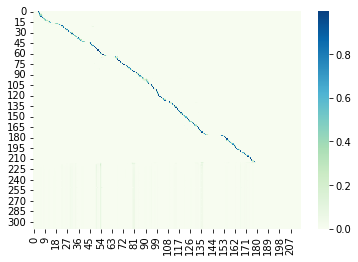

Train Epoch: 5 [25600/28539 (90%)]	Loss: 0.092940
Avg-distance: 16.06659


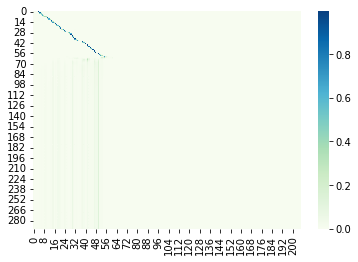

Train Epoch: 6 [0/28539 (0%)]	Loss: 0.090458


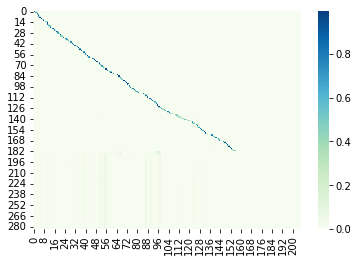

Train Epoch: 6 [6400/28539 (22%)]	Loss: 0.091380


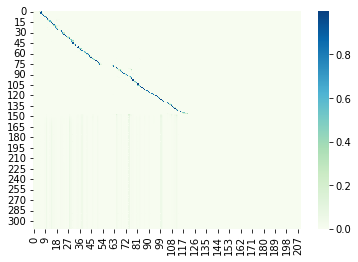

Train Epoch: 6 [12800/28539 (45%)]	Loss: 0.090765


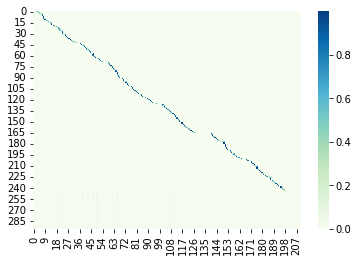

Train Epoch: 6 [19200/28539 (67%)]	Loss: 0.092004


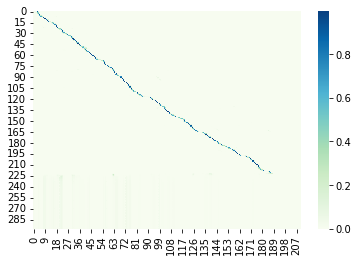

Train Epoch: 6 [25600/28539 (90%)]	Loss: 0.091493
Avg-distance: 16.57122


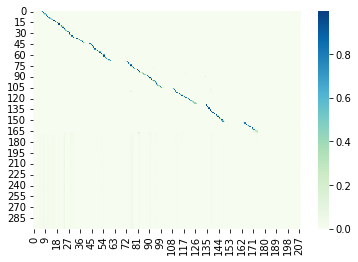

Train Epoch: 7 [0/28539 (0%)]	Loss: 0.095634


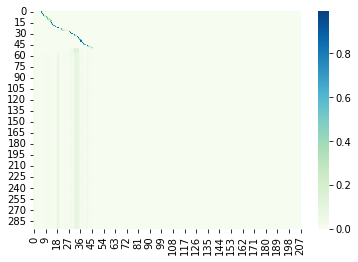

Train Epoch: 7 [6400/28539 (22%)]	Loss: 0.097954


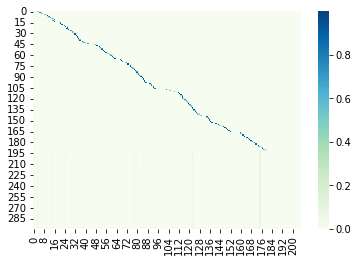

Train Epoch: 7 [12800/28539 (45%)]	Loss: 0.095136


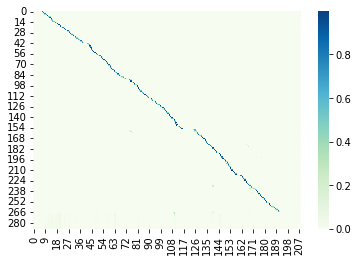

Train Epoch: 7 [19200/28539 (67%)]	Loss: 0.093523


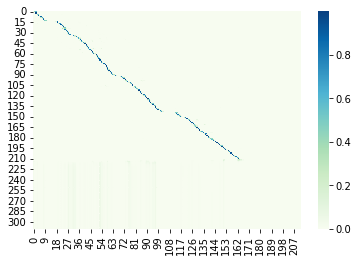

Train Epoch: 7 [25600/28539 (90%)]	Loss: 0.092708
Avg-distance: 14.67999


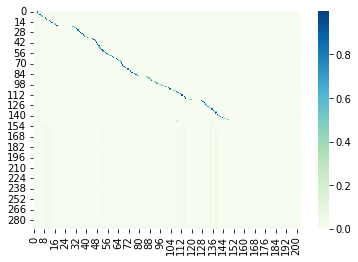

Train Epoch: 8 [0/28539 (0%)]	Loss: 0.078173


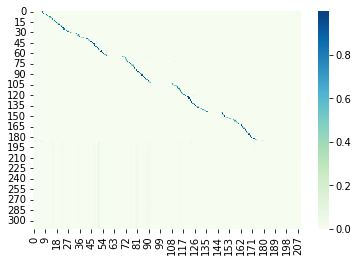

Train Epoch: 8 [6400/28539 (22%)]	Loss: 0.083217


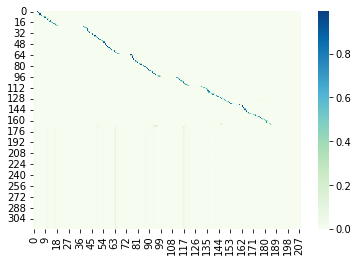

Train Epoch: 8 [12800/28539 (45%)]	Loss: 0.083663


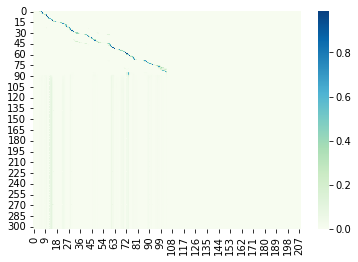

Train Epoch: 8 [19200/28539 (67%)]	Loss: 0.085188


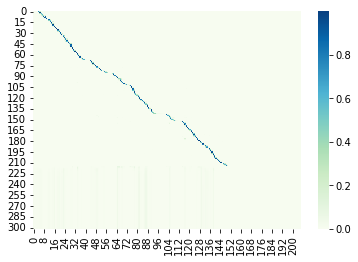

Train Epoch: 8 [25600/28539 (90%)]	Loss: 0.085349
Avg-distance: 14.05771


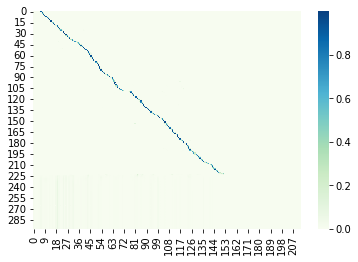

Train Epoch: 9 [0/28539 (0%)]	Loss: 0.079022


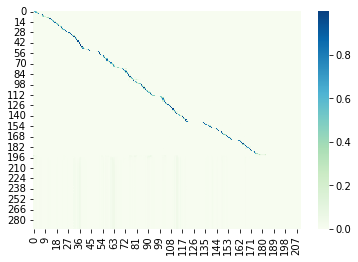

Train Epoch: 9 [6400/28539 (22%)]	Loss: 0.079477


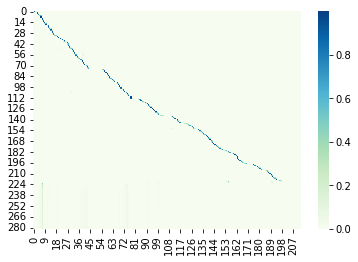

Train Epoch: 9 [12800/28539 (45%)]	Loss: 0.080958


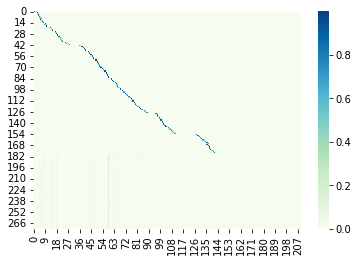

Train Epoch: 9 [19200/28539 (67%)]	Loss: 0.081249


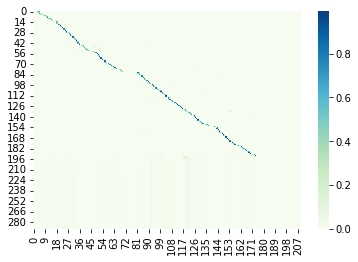

Train Epoch: 9 [25600/28539 (90%)]	Loss: 0.081243
Avg-distance: 13.09434


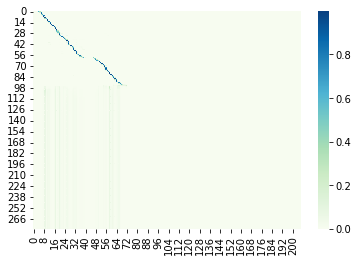

Train Epoch: 10 [0/28539 (0%)]	Loss: 0.084247


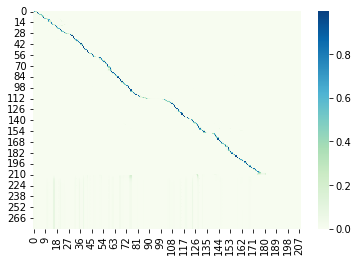

Train Epoch: 10 [6400/28539 (22%)]	Loss: 0.076265


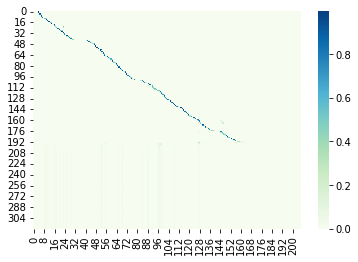

Train Epoch: 10 [12800/28539 (45%)]	Loss: 0.077186


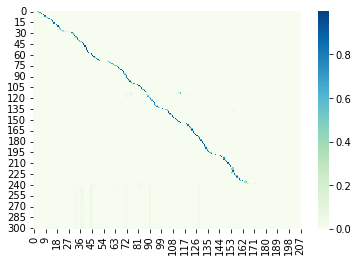

Train Epoch: 10 [19200/28539 (67%)]	Loss: 0.077134


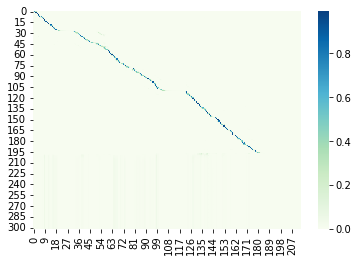

Train Epoch: 10 [25600/28539 (90%)]	Loss: 0.077733
Avg-distance: 13.75657


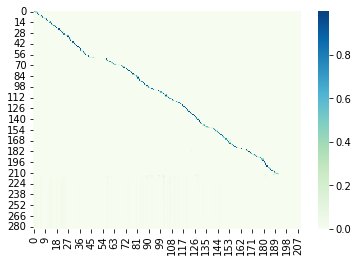

Train Epoch: 11 [0/28539 (0%)]	Loss: 0.075375


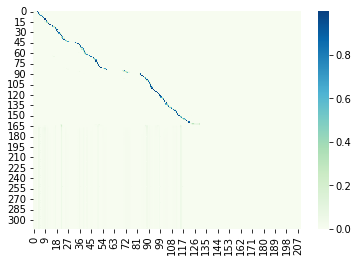

Train Epoch: 11 [6400/28539 (22%)]	Loss: 0.078011


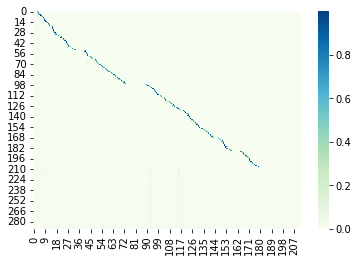

Train Epoch: 11 [12800/28539 (45%)]	Loss: 0.080314


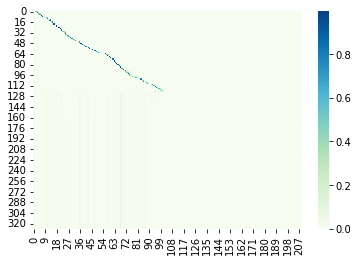

Train Epoch: 11 [19200/28539 (67%)]	Loss: 0.079843


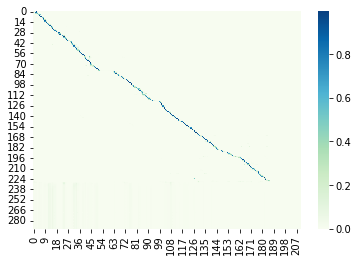

Train Epoch: 11 [25600/28539 (90%)]	Loss: 0.080397
Avg-distance: 13.34998


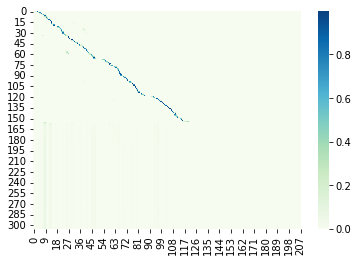

Train Epoch: 12 [0/28539 (0%)]	Loss: 0.059135


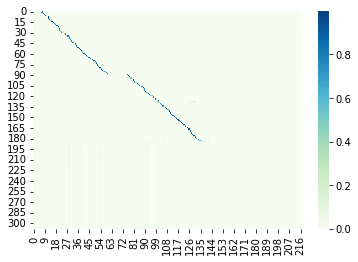

Train Epoch: 12 [6400/28539 (22%)]	Loss: 0.074046


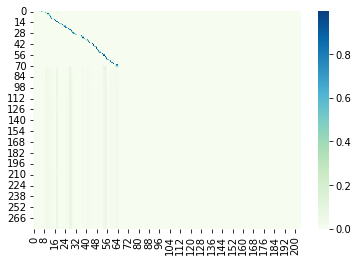

Train Epoch: 12 [12800/28539 (45%)]	Loss: 0.073918


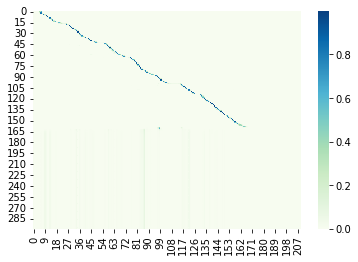

Train Epoch: 12 [19200/28539 (67%)]	Loss: 0.074259


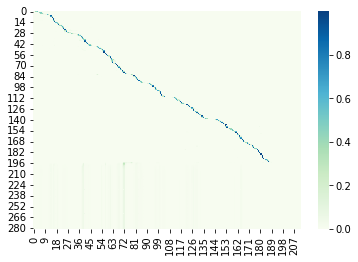

Train Epoch: 12 [25600/28539 (90%)]	Loss: 0.074860
Avg-distance: 12.57381


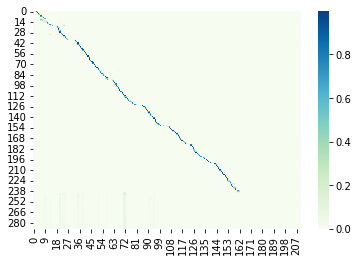

Train Epoch: 13 [0/28539 (0%)]	Loss: 0.060056


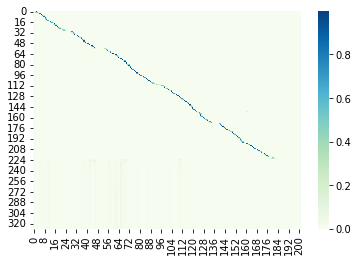

Train Epoch: 13 [6400/28539 (22%)]	Loss: 0.067991


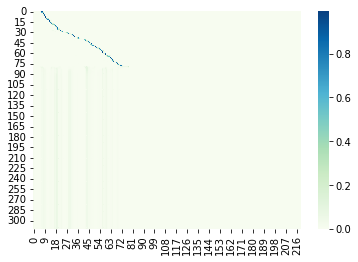

Train Epoch: 13 [12800/28539 (45%)]	Loss: 0.069069


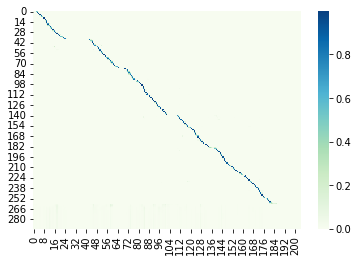

Train Epoch: 13 [19200/28539 (67%)]	Loss: 0.071032


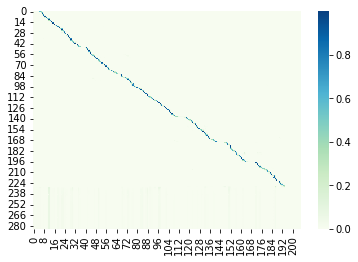

Train Epoch: 13 [25600/28539 (90%)]	Loss: 0.072605
Avg-distance: 12.93045


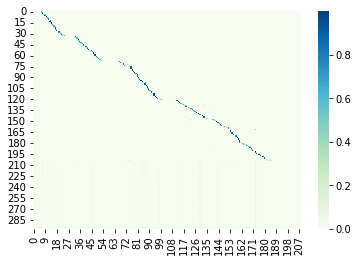

Train Epoch: 14 [0/28539 (0%)]	Loss: 0.065286


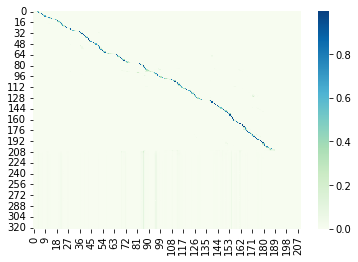

Train Epoch: 14 [6400/28539 (22%)]	Loss: 0.069178


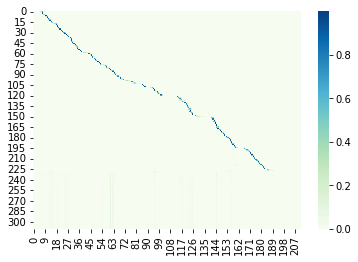

Train Epoch: 14 [12800/28539 (45%)]	Loss: 0.070959


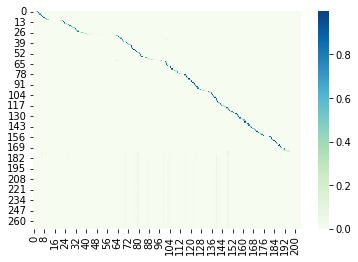

Train Epoch: 14 [19200/28539 (67%)]	Loss: 0.072230


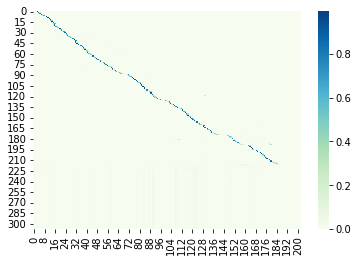

Train Epoch: 14 [25600/28539 (90%)]	Loss: 0.072144
Avg-distance: 13.01591


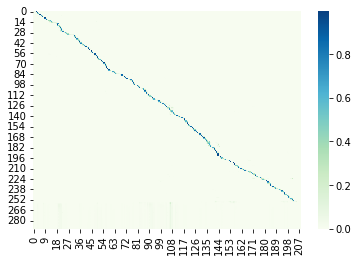

Train Epoch: 15 [0/28539 (0%)]	Loss: 0.070768


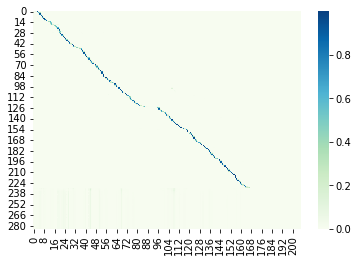

Train Epoch: 15 [6400/28539 (22%)]	Loss: 0.068971


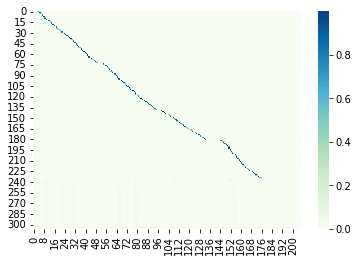

Train Epoch: 15 [12800/28539 (45%)]	Loss: 0.069457


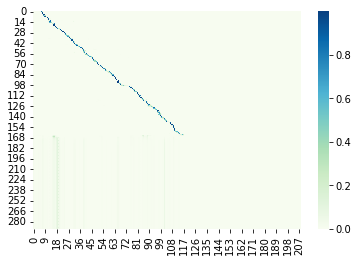

Train Epoch: 15 [19200/28539 (67%)]	Loss: 0.070084


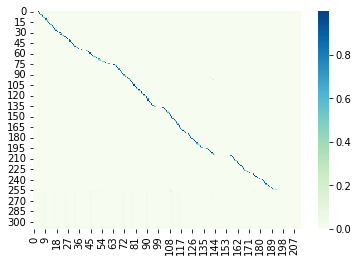

Train Epoch: 15 [25600/28539 (90%)]	Loss: 0.069832
Avg-distance: 12.61376


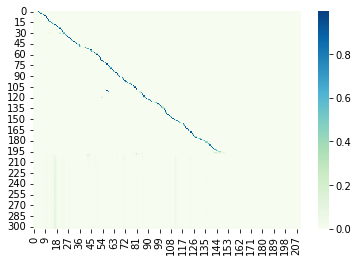

Train Epoch: 16 [0/28539 (0%)]	Loss: 0.063362


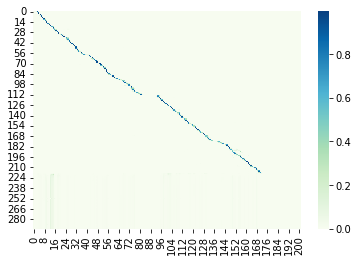

Train Epoch: 16 [6400/28539 (22%)]	Loss: 0.064858


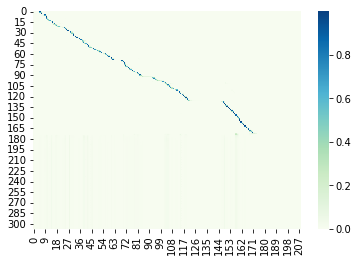

Train Epoch: 16 [12800/28539 (45%)]	Loss: 0.066146


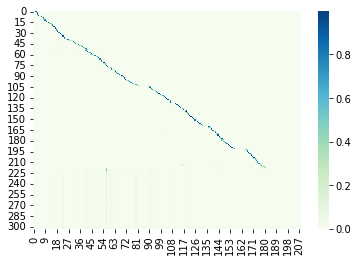

Train Epoch: 16 [19200/28539 (67%)]	Loss: 0.066852


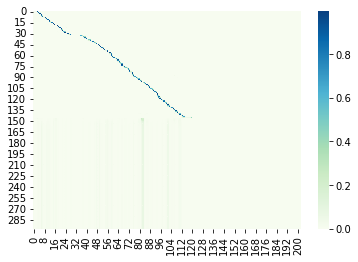

Train Epoch: 16 [25600/28539 (90%)]	Loss: 0.067675
Avg-distance: 13.29560


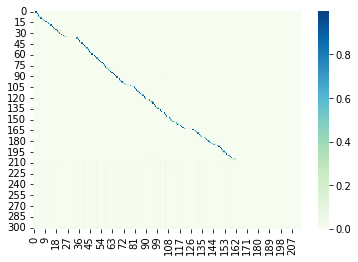

Train Epoch: 17 [0/28539 (0%)]	Loss: 0.069512


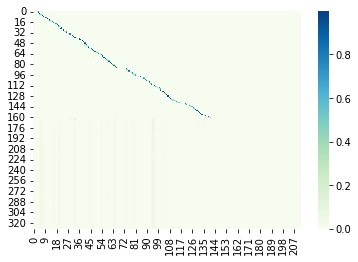

Train Epoch: 17 [6400/28539 (22%)]	Loss: 0.075945


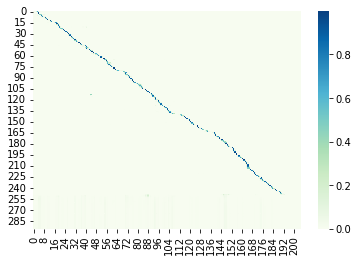

Train Epoch: 17 [12800/28539 (45%)]	Loss: 0.076886


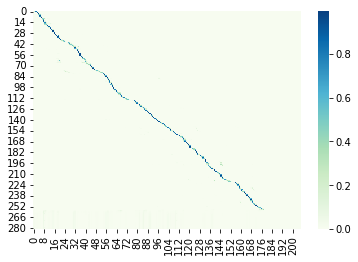

Train Epoch: 17 [19200/28539 (67%)]	Loss: 0.076221


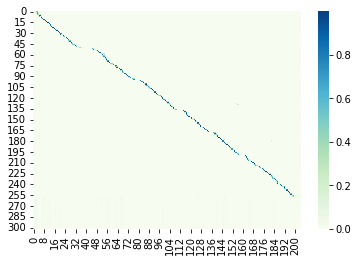

Train Epoch: 17 [25600/28539 (90%)]	Loss: 0.075413
Avg-distance: 12.10766


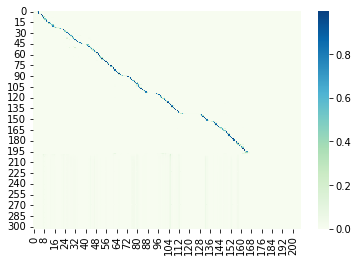

Train Epoch: 18 [0/28539 (0%)]	Loss: 0.067991


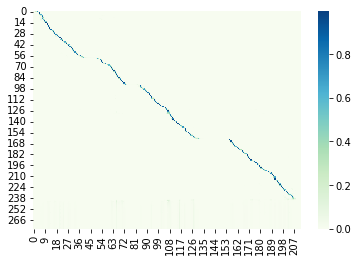

Train Epoch: 18 [6400/28539 (22%)]	Loss: 0.062980


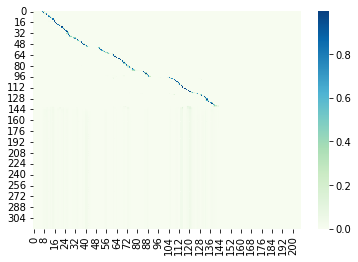

Train Epoch: 18 [12800/28539 (45%)]	Loss: 0.068110


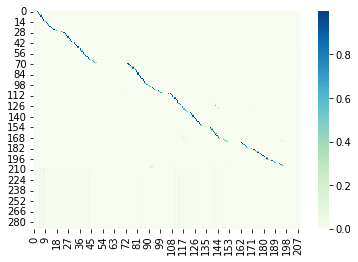

Train Epoch: 18 [19200/28539 (67%)]	Loss: 0.069627


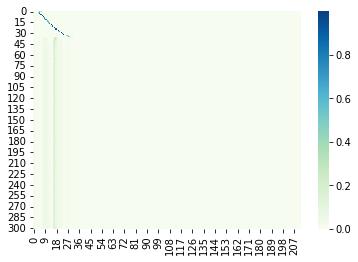

Train Epoch: 18 [25600/28539 (90%)]	Loss: 0.069704
Avg-distance: 12.05512


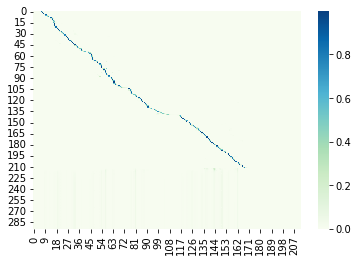

Train Epoch: 19 [0/28539 (0%)]	Loss: 0.054065


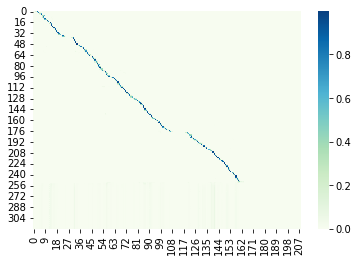

Train Epoch: 19 [6400/28539 (22%)]	Loss: 0.060787


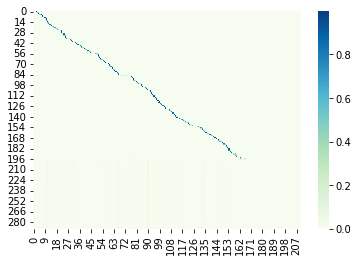

Train Epoch: 19 [12800/28539 (45%)]	Loss: 0.062197


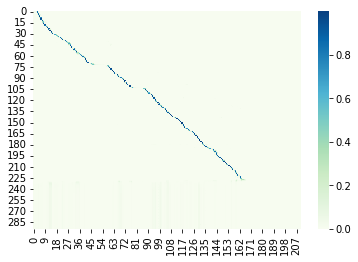

Train Epoch: 19 [19200/28539 (67%)]	Loss: 0.062870


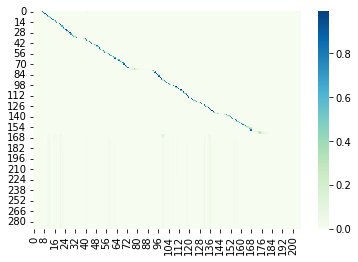

Train Epoch: 19 [25600/28539 (90%)]	Loss: 0.063108
Avg-distance: 13.26452


In [21]:
# TODO: Define your model and put it on the device here
# ...
mindist = 1000
n_epochs = 20
Teacher_forcing_rate = 0.9
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
# Make sure you understand the implication of setting reduction = 'none'
criterion = nn.CrossEntropyLoss(reduction='none', label_smoothing=1e-4).to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = (len(train_loader)*n_epochs))
scaler = torch.cuda.amp.GradScaler()
mode = 'train'

for epoch in range(n_epochs):
    train(model, train_loader, criterion, optimizer, mode,Teacher_forcing_rate, scaler)
    val_dist = val(model, val_loader)
    if epoch>7:
      scheduler.step(val_dist)
    if epoch%3==0 and epoch>7:
      Teacher_forcing_rate -= 0.1
      Teacher_forcing_rate = max(0.1, Teacher_forcing_rate)
    if val_dist < mindist:
      mindist = val_dist
      torch.save(model, '/content/drive/MyDrive/model6.pt')

In [19]:
torch.cuda.empty_cache()

In [22]:
model = torch.load('/content/drive/MyDrive/model6.pt')
predtext = evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [23]:
df = pd.read_csv('hw4p2_student_data/hw4p2_student_data/test/sample_submission.csv')
df['predictions'] = predtext
df.to_csv('hw4p2_student_data/hw4p2_student_data/test/submission.csv', index=False)

In [24]:
!kaggle competitions submit -c 11-785-s22-hw4p2-slack -f /content/hw4p2_student_data/hw4p2_student_data/test/submission.csv -m "Message"

100% 291k/291k [00:04<00:00, 73.5kB/s]
Successfully submitted to Attention-Based Speech Recognition (Slack)

In [ ]:
'''
Debugging suggestions from Eason, a TA from previous semesters:

(1) Decrease your batch_size to 2 and print out the value and shape of all intermediate variables to check if they satisfy the expectation
(2) Be super careful about the LR, don't make it too high. Too large LR would lead to divergence and your attention plot will never make sense
(3) Make sure you have correctly handled the situation for time_step = 0 when teacher forcing

(1) is super important and is the most efficient way for debugging. 
'''
'''
Tips for passing A from B (from easy to hard):
** You need to implement all of these yourself without utilizing any library **
(1) Increase model capacity. E.g. increase num_layer of lstm
(2) LR and Teacher Forcing are also very important, you can tune them or their scheduler as well. Do NOT change lr or tf during the warm-up stage!
(3) Weight tying
(4) Locked Dropout - insert between the plstm layers
(5) Pre-training decoder or train an LM to help make predictions
(5) Pre-training decoder to speed up the convergence: 
    disable your encoder and only train the decoder like train a language model
(6) Better weight initialization technique
(7) Batch Norm between plstm. You definitely can try other positions as well
(8) Data Augmentation. Time-masking, frequency masking
(9) Weight smoothing (avg the last few epoch's weight)
(10) You can try CNN + Maxpooling (Avg). Some students replace the entire plstm blocks with it and some just combine them together.
(11) Beam Search
'''